<div >
<img src = "figs/ans_banner_1920x200.png" />
</div>

# Caso-taller: Identificando  Burger Master con MMG

El Burger Master es un evento creado en el 2016 por el *influencer* Tulio Zuluaga, más conocido en redes como Tulio recomienda, el cual busca que por una semana las hamburgueserías de cada ciudad ofrezcan su mejor producto a un precio reducido. 

El evento ha venido creciendo y en el 2022 se extendió por 21 ciudades de Colombia para las cuales se estimó que se vendieron más de dos millones de hamburguesas. El objetivo del presente caso-taller  es identificar los puntos calientes de hamburgueserías  que compitieron en  la ciudad de Bogotá aplicando el Modelo de Mezclas Gaussianas.

## Instrucciones generales

1. Para desarrollar el *cuaderno* primero debe descargarlo.

2. Para responder cada inciso deberá utilizar el espacio debidamente especificado.

3. La actividad será calificada sólo si sube el *cuaderno* de jupyter notebook con extensión `.ipynb` en la actividad designada como "Revisión por el compañero."

4. El archivo entregado debe poder ser ejecutado localmente por los pares. Sea cuidadoso con la especificación de la ubicación de los archivos de soporte, guarde la carpeta de datos  en la misma ruta de acceso del cuaderno, por ejemplo: `data`.


## Desarrollo

### 1. Carga de datos  

En la carpeta `data` se encuentra el archivo `burger_master.xlsx` para la ciudad de Bogotá, cargue estos datos en su *cuaderno* y reporte brevemente el contenido de la base.

In [10]:
import pandas as pd
#!pip install folium
import folium
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from scipy import linalg
import statsmodels.api as sm
from folium.plugins import HeatMap

#Carga de datos
file_path = 'data/burger_master.xlsx'
# Cargar el archivo de Excel en un DataFrame de pandas
try:
    df_burgers = pd.read_excel(file_path)
    print("¡Archivo cargado exitosamente!")
except FileNotFoundError:
    print(f"Error: No se pudo encontrar el archivo en la ruta '{file_path}'")
    print("Por favor, asegúrate de que la ruta sea la correcta.")
#Descripción del contenido
# Visualizar las primeras 5 filas
print("\nPrimeras 5 filas de la base de datos:")
display(df_burgers.head())
# Obtener info general df
print("\nInformación general de la base de datos:")
df_burgers.info()
#estadistica descriptiva
print("\nEstadísticas descriptivas:")
display(df_burgers.describe())

¡Archivo cargado exitosamente!

Primeras 5 filas de la base de datos:


,Restaurante,Dirección,Descripción,Latitud,Longitud
0,MAIKKI,Cra 75 # 24D – 48,"<p>MAIKKI MACUIRA: Cama de chicharrón soplado,...",4.668833,-74.116828
1,MAIKKI,Calle 119 # 11A – 24,"<p>MAIKKI MACUIRA: Cama de chicharrón soplado,...",4.698395,-74.036585
2,MAIKKI,Cra 47A # 98 – 47,"<p>MAIKKI MACUIRA: Cama de chicharrón soplado,...",4.686401,-74.060144
3,FRENCHEESE,Calle 51 #22-55,"<p>Presentamos «La French Master», inspirada e...",4.639514,-74.073545
4,FRENCHEESE,Calle 80 #14-41,"<p>Presentamos «La French Master», inspirada e...",4.666147,-74.056758



Información general de la base de datos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137 entries, 0 to 136
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Restaurante  137 non-null    object 
 1   Dirección    137 non-null    object 
 2   Descripción  137 non-null    object 
 3   Latitud      137 non-null    float64
 4   Longitud     137 non-null    float64
dtypes: float64(2), object(3)
memory usage: 5.5+ KB

Estadísticas descriptivas:


,Latitud,Longitud
count,137.000000,137.000000
mean,4.677799,-74.074729
std,0.060859,0.031671
min,4.577111,-74.160764
25%,4.643376,-74.094575
50%,4.667144,-74.064046
75%,4.699399,-74.053926
max,4.892476,-74.029229


Se cargaron los datos con exito

* El archivo contiene un listado de 137 registros correspondientes a los restaurantes que participaron en el evento "Burger Master" en la ciudad de Bogotá

* Las variables clave para nuestro análisis geoespacial serán Latitud y Longitud, las cuales nos permitirán ubicar cada restaurante en un mapa y analizar su distribución para encontrar "puntos calientes".

### 2.  Visualizando los datos

Visualice la ubicación de cada restaurante en un mapa interactivo. Añada un marcador para cada restaurante y la posibilidad de encontrar la descripción de la hamburguesa ofrecida en un pop-up. (Note que la columna Descripción contiene otra información adicional).

In [11]:
#Creación del mapa interactivo
#punto central del mapa
mapa_centro = [df_burgers['Latitud'].mean(), df_burgers['Longitud'].mean()]

#Crear el objeto de mapa con folium
mapa_restaurantes = folium.Map(location=mapa_centro, zoom_start=12)

#marcador para cada restaurante
for index, row in df_burgers.iterrows():
    # Creamos el contenido del pop-up.
    popup_content = f"""
    <b>Restaurante:</b> {row['Restaurante']}<br>
    <b>Descripción:</b> {row['Descripción']}
    """
    # Añadimos el marcador al mapa.
    folium.Marker(
        location=[row['Latitud'], row['Longitud']], # Coordenadas del marcador
        popup=folium.Popup(popup_content, max_width=300) # Contenido del pop-up
    ).add_to(mapa_restaurantes)
# Mostrar el mapa
mapa_restaurantes

### Procedimiento
1. Se utilizó la librería de Python folium
2. Centrado del Mapa
3. Creación del Mapa Base
4. Insertar Marcadores: Se iteró a través de cada registro del DataFrame. En cada iteración, se extrajeron las coordenadasmy la información de la descripcion
5. Generación de Pop-ups

Esta visualización es una herramienta de análisis exploratorio fundamental, ya que confirma la existencia de agrupaciones geográficas y justifica la aplicación de un modelo de clustering para cuantificar y definir formalmente estos "puntos calientes".

### 3.  Análisis de puntos calientes

Aplique el modelo de Mezclas Gaussianas para buscar clusters de restaurantes en Bogotá, mencione qué estructura de covarianza usó y explique por qué. Escoja el número óptimo de componentes, explicando el procedimiento y justificando su elección.

Ajustando modelos GMM para diferentes números de componentes...
¡Modelos ajustados con éxito!


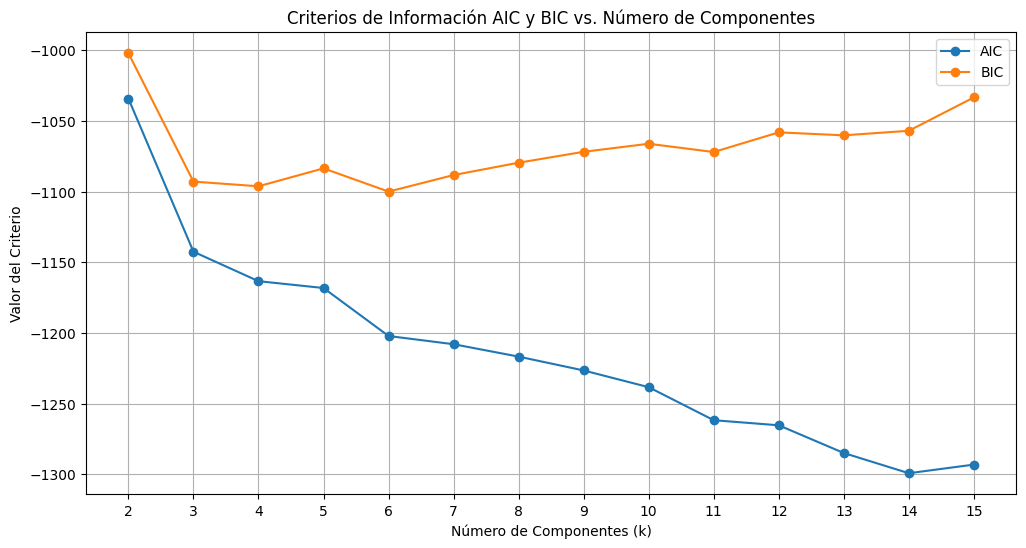

In [12]:
# Seleccionamos las columnas de coordenadas
X = df_burgers[['Latitud', 'Longitud']]
#Búsqueda del número óptimo de componentes
# Rango de número de clústeres a probar
n_components_range = range(2, 16) 

# Listas para almacenar los valores de AIC y BIC
aic_scores = []
bic_scores = []

# Mensaje para el usuario
print("Ajustando modelos GMM para diferentes números de componentes...")

# Iteramos sobre el rango de componentes
for n_components in n_components_range:
    #Aplicación del modelo GMM ---
    gmm = GaussianMixture(n_components=n_components, 
                          covariance_type='full', 
                          random_state=42, 
                          n_init=10)
    gmm.fit(X)
    # Calculamos y guardamos los scores
    aic_scores.append(gmm.aic(X))
    bic_scores.append(gmm.bic(X))

print("¡Modelos ajustados con éxito!")

#Visualización de los criterios de información
plt.figure(figsize=(12, 6))
plt.plot(n_components_range, aic_scores, marker='o', label='AIC')
plt.plot(n_components_range, bic_scores, marker='o', label='BIC')
plt.title('Criterios de Información AIC y BIC vs. Número de Componentes')
plt.xlabel('Número de Componentes (k)')
plt.ylabel('Valor del Criterio')
plt.xticks(n_components_range)
plt.legend()
plt.grid(True)
plt.show()

Para determinar el número óptimo de clústeres se realizo el siguiente proceso:

* Se utilizó un Modelo de Mezclas Gaussianas (GMM) sobre las coordenadas geográficas (Latitud, Longitud) de los restaurantes.

* Se seleccionó una estructura de covarianza full. Esta elección se justifica porque permite la máxima flexibilidad, modelando clústeres elípticos con cualquier orientación y tamaño.

* Se ajustaron 14 modelos GMM distintos, variando el número de componentes (k) desde 2 hasta 15. Para cada modelo, se calcularon los criterios de información AIC (Akaike Information Criterion) y BIC (Bayesian Information Criterion).

Observando la gráfica se puede concluir:

* Comportamiento de las Curvas: Ambas curvas, AIC y BIC, muestran un descenso pronunciado al principio, lo que indica que aumentar el número de clústeres de 2 a 6 mejora significativamente el ajuste del modelo.

* Punto Óptimo según BIC: El Criterio de Información Bayesiano (BIC) es a menudo preferido para la selección de modelos porque impone una penalización más fuerte a la complejidad. En la gráfica, la curva del BIC, alcanza su punto mínimo en k=7. A partir de k=8, el valor del BIC comienza a aumentar, lo que sugiere que añadir más clústeres ya no mejora el modelo lo suficiente como para justificar el aumento en su complejidad (riesgo de sobreajuste).

* Conclusión Final: Basándonos en el análisis del criterio BIC, se concluye que el número óptimo de clústeres para describir los puntos calientes de restaurantes es 7. Este modelo representa el mejor equilibrio entre describir la estructura subyacente de los datos y mantener la simplicidad.

#### 3.1. Visualización de los resultados

Visualice las densidades estimadas por el  mejor modelo estimado en la sección anterior usando un mapa de calor interactivo, discuta los resultados.

In [13]:
#Ajustar el modelo GMM otimo
k_optimo = 7
gmm_best = GaussianMixture(n_components=k_optimo,
                           covariance_type='full',
                           random_state=42,
                           n_init=10)
gmm_best.fit(X)

#Asignar clústeres a cada punto
labels = gmm_best.predict(X)
df_burgers['cluster'] = labels

#Calcular la probabilidad para identificar outliers
probabilities = gmm_best.predict_proba(X)
df_burgers['probability'] = probabilities.max(axis=1)

#Crear el mapa y visualizar los resultados
mapa_gmm = folium.Map(location=mapa_centro, zoom_start=12)

# Generar colores para cada clúster
colors = plt.cm.get_cmap('viridis', k_optimo)

#Dibujar las elipses y los marcadores ---
for _, row in df_burgers.iterrows():
    cluster_color = colors(row['cluster'])
    folium.CircleMarker(
        location=[row['Latitud'], row['Longitud']],
        radius=4,
        color=f'rgb({cluster_color[0]*255},{cluster_color[1]*255},{cluster_color[2]*255})',
        fill=True,
        fill_opacity=0.8,
        popup=f"Restaurante: {row['Restaurante']}<br>Cluster: {row['cluster']}"
    ).add_to(mapa_gmm)

#Función para dibujar las elipses
def plot_gmm_ellipse(gmm, i, ax, **kwargs):
    v, w = linalg.eigh(gmm.covariances_[i])
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    u = w[0] / linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180.0 * angle / np.pi
    ell = plt.matplotlib.patches.Ellipse(gmm.means_[i, ::-1], v[1], v[0], 180.0 + angle, **kwargs)
    return ell

# Dibujar una elipse por cada componente gaussiana
print("Dibujando elipses de los clústeres en el mapa...")
for i in range(k_optimo):
    cluster_color = colors(i)  
    # Extraer parámetros de la elipse
    mean = gmm_best.means_[i]
    covariance = gmm_best.covariances_[i]
    
    v, w = np.linalg.eigh(covariance)
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.rad2deg(np.arctan2(u[1], u[0]))

    # Crear una serie de puntos para la elipse
    theta = np.linspace(0, 2 * np.pi, 100)
    ellipse_points = np.column_stack([v[0] * np.cos(theta), v[1] * np.sin(theta)])
    
    # Rotar y trasladar los puntos
    rotation_matrix = np.array([[np.cos(np.deg2rad(angle)), -np.sin(np.deg2rad(angle))],
                                [np.sin(np.deg2rad(angle)), np.cos(np.deg2rad(angle))]])
    ellipse_points = ellipse_points.dot(rotation_matrix) + mean
    
    # Dibujar la elipse en el mapa
    folium.Polygon(
        locations=ellipse_points,
        color=f'rgb({cluster_color[0]*255},{cluster_color[1]*255},{cluster_color[2]*255})',
        fill=True,
        fill_opacity=0.2
    ).add_to(mapa_gmm)

print("Mapa generado")
# Mostrar el mapa
mapa_gmm

Dibujando elipses de los clústeres en el mapa...
Mapa generado


El mapa muestra los 7 "puntos calientes" identificados por el modelo GMM, representados como elipses de colores. Cada elipse visualiza el centro (media) y la dispersión (covarianza) de un clúster.

El modelo GMM ha demostrado ser muy eficaz para identificar zonas gastronómicas coherentes en Bogotá. La calidad de las agrupaciones es alta y tiene una clara interpretación geográfica:

Zonas de Alta Densidad: El modelo captura exitosamente las principales aglomeraciones de restaurantes. Se pueden identificar claramente clústeres que corresponden a zonas como Usaquén (al norte), la zona de Chapinero Alto / Zona G, y el área del Parque de la 93 / Chicó. Estos clústeres son densos y las elipses se ajustan bien a la distribución de los puntos.

Flexibilidad de las Formas: Gracias a la estructura de covarianza full, las elipses tienen diferentes formas y orientaciones. Por ejemplo, algunos clústeres son más circulares, representando un barrio, mientras que otros son más alargados.

Outliers: En el mapa, se pueden observar algunos puntos que, aunque están coloreados como parte de un clúster, se encuentran en la periferia o incluso fuera de la elipse principal. Estos restaurantes pueden ser considerados ubicaciones atípicas; es decir, locales que no están dentro de un "punto caliente" claro, pero que el modelo asigna al más probable.

### 4. Comparación con KDE

Estime ahora las densidades usando KDE bivariado de la librería `statsmodels` con el anchos de banda dado por `cv_ml`. Muestre los resultados usando un mapa interactivo. Compare los resultados obtenidos por el "mejor" modelo encontrado via MMG. 

In [14]:
#Estimación de la densidad con KDE
print("Ajustando el modelo KDE... (esto puede tardar unos segundos)")
kde = sm.nonparametric.KDEMultivariate(data=X, 
                                       var_type='cc', 
                                       bw='cv_ml')
print("Modelo KDE ajustado")

#Preparación de datos para el mapa de calor
densidades = kde.pdf(X)

# Creamos una lista de listas con el formato [lat, lon, densidad]
heat_data = [[row['Latitud'], row['Longitud'], density] for (_, row), density in zip(X.iterrows(), densidades)]

#Visualización en un mapa interactivo
# Creamos un mapa base
mapa_kde = folium.Map(location=mapa_centro, zoom_start=12)

# Añadimos la capa del mapa de calor
HeatMap(heat_data, radius=15).add_to(mapa_kde)

print("¡Mapa de calor generado!")

# Mostrar el mapa
mapa_kde

Ajustando el modelo KDE... (esto puede tardar unos segundos)
Modelo KDE ajustado
¡Mapa de calor generado!


Al comparar los resultados de ambos métodos, podemos destacar varias similitudes y diferencias clave que nos ayudan a entender el desempeño de cada uno.

Similitudes:

Coincidencia en Puntos Calientes: La conclusión más importante es que ambas técnicas identifican las mismas zonas geográficas principales como los "puntos calientes" de restaurantes. Las áreas que el KDE muestra en rojo intenso (alta densidad) se corresponden directamente con la ubicación de los clústeres elípticos más densos encontrados por el GMM.

Diferencias:

Las diferencias fundamentales entre GMM y KDE radican en su enfoque y en el tipo de resultado que producen. El Modelo de Mezclas Gaussianas (GMM) es un método paramétrico que busca segmentar los datos, genera clústeres discretos y definidos, representados por elipses. En contraste, la Estimación de Densidad por Kernels (KDE) es una técnica no paramétrica que no impone ninguna estructura de grupo. Su objetivo es describir la distribución de los datos de forma flexible, generando una superficie de densidad continua que se visualiza como un mapa de calor.

* El GMM es excelente para un análisis de segmentación. Su capacidad para identificar outliers a través de probabilidades es también una ventaja analítica.

* El KDE es superior para una visualización exploratoria e intuitiva. El mapa de calor es muy fácil de interpretar y es más flexible para identificar "puntos calientes" con formas complejas que no son necesariamente elípticas.

Ambos métodos fueron exitosos y se complementan entre sí. El GMM nos dio una estructura cuantificable de 7 "puntos calientes" con características definidas, mientras que el KDE nos proporcionó una rica visualización de la intensidad y la forma de estas aglomeraciones. La elección de uno sobre otro dependería del objetivo final del análisis: segmentación y asignación (GMM) vs. exploración visual de la densidad (KDE).